# Predicing 5k performance for college athletes

#### this notebook takes data that was scraped form tfrrs.org, engineers features, and uses a CATBoost Algoithm to predict performances for college athletes

### import libraries

In [27]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import importlib
import matplotlib.dates as mdates

### read the dataframe containing the raw scraped data

In [28]:
file_path = r'C:\Users\leopo\OneDrive\Documents\coding\projects\tfrrs_scraper\data\2015_to_2024'


data = pd.read_feather(file_path)

### view a sample of the data
#### this is what the scraped data looks like. very few transformation has been done at this point

In [29]:
pd.set_option('display.max_columns', None)
data.head(10)

,athlete_name,last_name,first_name,athlete_id,year_when_scraped,school,school_scraped_url,division,region,main_conference,other_conferences_found,gender,transfers,has_transferred,meet_name,meet_date,events_competed_in_meet,event,n_event_of_meet,performance,place,event_stage,wind,meet_type,scraped_for_school,athlete_url,year_scraped_roster,year_scraped_season,year_scraped_year,school_roster_size,parsed_date,converted_performance,granular_performance,school_state
0,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Northeast Conference Championship,"May 2- 3, 2015",3,SP,1,11.74m,9th,F,(+0.0),tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723706/Mount_S...,2015,outdoor,2015,27,2015-05-02,0 days 00:00:11.740000,11.74,MD
1,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Northeast Conference Championship,"May 2- 3, 2015",3,DT,2,34.52m,16th,F,(+0.0),tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723706/Mount_S...,2015,outdoor,2015,27,2015-05-02,0 days 00:00:34.520000,34.52,MD
2,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Northeast Conference Championship,"May 2- 3, 2015",3,HT,3,49.65m,5th,F,(+0.0),tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723706/Mount_S...,2015,outdoor,2015,27,2015-05-02,0 days 00:00:49.650000,49.65,MD
3,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Bucknell Team Challenge,"Apr 18, 2015",3,SP,1,10.79m,14th,F,,tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723706/Mount_S...,2015,outdoor,2015,27,2015-04-18,0 days 00:00:10.790000,10.79,MD
4,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Bucknell Team Challenge,"Apr 18, 2015",3,DT,2,35.42m,14th,F,,tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723706/Mount_S...,2015,outdoor,2015,27,2015-04-18,0 days 00:00:35.420000,35.42,MD
5,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Bucknell Team Challenge,"Apr 18, 2015",3,HT,3,50.14m,4th,F,,tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723706/Mount_S...,2015,outdoor,2015,27,2015-04-18,0 days 00:00:50.140000,50.14,MD
6,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Mason Spring Invitational,"Apr 11, 2015",3,SP,1,11.38m,24th,F,,tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723706/Mount_S...,2015,outdoor,2015,27,2015-04-11,0 days 00:00:11.380000,11.38,MD
7,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Mason Spring Invitational,"Apr 11, 2015",3,DT,2,36.14m,17th,F,,tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723706/Mount_S...,2015,outdoor,2015,27,2015-04-11,0 days 00:00:36.140000,36.14,MD
8,ALEXANDRIA DONAHUE,Donahue,Alexandria,81_S'YRAM-.TS-TNUOM_EUHANODAIRDNAXELA,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Mason Spring Invitational,"Apr 11, 201

#### check how many men and women are available in total

In [30]:

print(f' men count: {data[(data['meet_type']=='tf')& (data['gender']=='M')]['athlete_id'].nunique()}')

print(f' women count: {data[(data['meet_type']=='tf')& (data['gender']=='F')]['athlete_id'].nunique()}')

 men count: 135316
 women count: 131157


### filter dataframe for only 5k runners
#### these are the runners we will use to train the model

In [31]:
# get unique 5k runners

fivek_athlete_ids = data[(data['meet_type'] == 'tf') & (data['event'] == '5000')]['athlete_id'].unique()

print(f'number of unique 5k runners: {len(fivek_athlete_ids)}')

# filter to only the relevant runners

relevant_runners = data[data['athlete_id'].isin(fivek_athlete_ids)]

relevant_runners.head(3)

number of unique 5k runners: 57363


,athlete_name,last_name,first_name,athlete_id,year_when_scraped,school,school_scraped_url,division,region,main_conference,other_conferences_found,gender,transfers,has_transferred,meet_name,meet_date,events_competed_in_meet,event,n_event_of_meet,performance,place,event_stage,wind,meet_type,scraped_for_school,athlete_url,year_scraped_roster,year_scraped_season,year_scraped_year,school_roster_size,parsed_date,converted_performance,granular_performance,school_state
111,MCKENZIE DOYLE,Doyle,McKenzie,41_S'YRAM-.TS-TNUOM_ELYODEIZNEKCM,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Northeast Conference Championship,"May 2- 3, 2015",2,5000,1,19:10.93,18th,F,,tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723707/Mount_S...,2015,outdoor,2015,27,2015-05-02,0 days 00:19:10.930000,1150.93,MD
112,MCKENZIE DOYLE,Doyle,McKenzie,41_S'YRAM-.TS-TNUOM_ELYODEIZNEKCM,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Northeast Conference Championship,"May 2- 3, 2015",2,"10,000",2,40:28.01,14th,F,,tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723707/Mount_S...,2015,outdoor,2015,27,2015-05-02,0 days 00:40:28.010000,2428.01,MD
113,MCKENZIE DOYLE,Doyle,McKenzie,41_S'YRAM-.TS-TNUOM_ELYODEIZNEKCM,SR-4,MOUNT ST. MARY'S,https://tf.tfrrs.org/teams/tf/MD_college_f_Mou...,DI,Mid-Atlantic Region,Metro Atlantic,[IC4A/ECAC],F,None,0,Mason Spring Invitational,"Apr 11, 2015",1,5000,1,18:28.82,18th,F,,tf,MOUNT ST. MARY'S,https://www.tfrrs.org/athletes/3723707/Mount_S...,2015,outdoor,2015,27,2015-04-11,0 days 00:18:28.820000,1108.82,MD


### now we get the fastest 5k time for each unique runner
#### this is the time that we are going to try to predict (the target)
#### we need the athleteid, their fastest 5k, and the date of when they ran their fastest 5k

In [32]:
# Filter the data for event == 5000 and meet_type == 'tf'
only_5000 = relevant_runners[(relevant_runners['event'] == '5000') & (relevant_runners['meet_type'] == 'tf')]

# Remove athletes whose only 5000-meter entry has NaN in granular_performance
athlete_counts = only_5000.groupby('athlete_id').size()
athletes_to_drop = athlete_counts[athlete_counts == 1].index

# Filter out those athletes whose performance is NaN
only_5000_cleaned = only_5000[~((only_5000['athlete_id'].isin(athletes_to_drop)) & (only_5000['granular_performance'].isna()))]

# Sort by athlete_id and granular_performance (ascending for fastest), disregarding NaN values
sorted_for_athletes = only_5000_cleaned.sort_values(by=['athlete_id', 'granular_performance'], na_position='last')

# Get the fastest performance for each athlete
model_df = sorted_for_athletes.groupby('athlete_id').head(1)[['athlete_id', 'granular_performance', 'parsed_date']]

# Reset index if needed
model_df.reset_index(drop=True, inplace=True)

model_df.head(10)


,athlete_id,granular_performance,parsed_date
0,01_).AG(-LEUNAMME_THGIRWCAZ,1021.72,2022-04-16
1,01_).ALF(-IMAIM_HCOKAILUJ,1164.62,2014-03-21
2,01_).AP(-AINROFILAC_AZZEPKCIN,952.57,2012-02-18
3,01_).AP(-AINROFILAC_EBOJNOSAM,957.98,2021-04-03
4,01_).AP(-AINROFILAC_ECNAVARAS,1163.20,2019-03-30
5,01_).AP(-AINROFILAC_GNUOYTTAM,1002.68,2019-04-06
6,01_).AP(-AINROFILAC_ONAILUEOJ,938.78,2019-04-13
7,01_).AP(-AINROFILAC_TNEKYBLOK,967.74,2024-03-29
8,01_).AP(-ANAIDNI_ADOHNORAA,999.56,2018-04-21
9,01_).AP(-ANAIDNI_ALLESTTAM,1012.82,2017-12-01


### check the data types

In [33]:
model_df.dtypes

athlete_id                      object
granular_performance           float64
parsed_date             datetime64[ns]
dtype: object

## some EDA

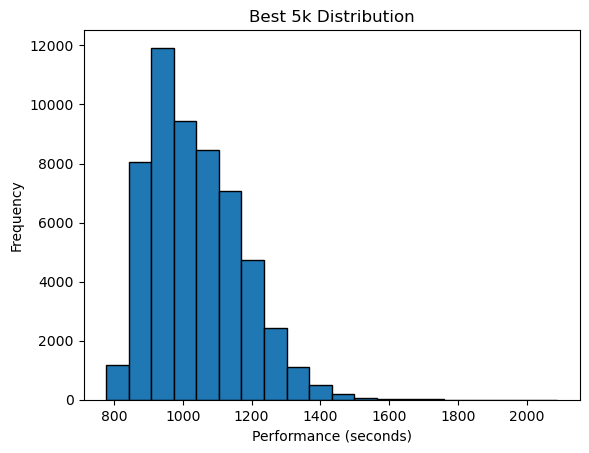

In [34]:
plt.hist(model_df['granular_performance'], bins=20, edgecolor='black')
plt.title('Best 5k Distribution')
plt.xlabel('Performance (seconds)')
plt.ylabel('Frequency')
plt.show()

## start adding features for the model

#### getting the gender of each athlete

In [35]:
# Step 1: Find athlete_ids with conflicting genders
conflicting_athletes = (
    relevant_runners.groupby('athlete_id')['gender']
    .nunique()
)
conflicting_athletes = conflicting_athletes[conflicting_athletes > 1].index

# Step 2: Build a clean athlete_id -> gender mapping, excluding conflicts
athlete_gender = (
    relevant_runners[~relevant_runners['athlete_id'].isin(conflicting_athletes)]
    .groupby('athlete_id', as_index=False)['gender']
    .first()
)

# Step 3: Merge gender into model_df (only non-conflicting athletes remain)
model_df = model_df.merge(athlete_gender, on='athlete_id', how='left')


### getting the fastest performances for a few events (800,1500,Mile,10k) before the best 5k, including how many days before the 5k PR it was ran
#### creating a helperfunction for assistance

In [36]:
# Helper function: get fastest performance & days before 5k PR
def get_fastest_before_5k(df, event_name, col_prefix, model_df_df):
    # Join with 5k PR date
    df = df[df['event'] == event_name].merge(
        model_df_df[['athlete_id', 'parsed_date']], 
        on='athlete_id', 
        how='inner', 
        suffixes=('', '_5k')
    )
    
    # Keep only performances before the 5k PR date
    df = df[df['parsed_date'] < df['parsed_date_5k']]
    
    # Pick fastest per athlete
    fastest = (
        df.sort_values(by=['athlete_id', 'granular_performance'])
          .groupby('athlete_id', as_index=False)
          .first()[['athlete_id', 'granular_performance', 'parsed_date', 'parsed_date_5k']]
    )
    
    # Compute days before 5k PR
    fastest[col_prefix + '_days_before_5k'] = (
        (fastest['parsed_date_5k'] - fastest['parsed_date']).dt.days
    )
    
    # Keep only needed columns
    fastest = fastest.rename(columns={'granular_performance': col_prefix})
    fastest = fastest[['athlete_id', col_prefix, col_prefix + '_days_before_5k']]
    
    return fastest


# Build features for each target event (with exact event names!)
fastest_10000 = get_fastest_before_5k(relevant_runners, '10,000', 'fastest_10000', model_df)
fastest_mile  = get_fastest_before_5k(relevant_runners, 'Mile',   'fastest_mile',  model_df)
fastest_1500  = get_fastest_before_5k(relevant_runners, '1500',   'fastest_1500',  model_df)
fastest_800   = get_fastest_before_5k(relevant_runners, '800',    'fastest_800',   model_df)

# Merge into model_df
model_df = (
    model_df.merge(fastest_10000, on='athlete_id', how='left')
          .merge(fastest_mile,  on='athlete_id', how='left')
          .merge(fastest_1500,  on='athlete_id', how='left')
          .merge(fastest_800,   on='athlete_id', how='left')
)


model_df.head(3)


,athlete_id,granular_performance,parsed_date,gender,fastest_10000,fastest_10000_days_before_5k,fastest_mile,fastest_mile_days_before_5k,fastest_1500,fastest_1500_days_before_5k,fastest_800,fastest_800_days_before_5k
0,01_).AG(-LEUNAMME_THGIRWCAZ,1021.72,2022-04-16,M,2139.98,393.0,294.85,427.0,NaN,NaN,NaN,NaN
1,01_).ALF(-IMAIM_HCOKAILUJ,1164.62,2014-03-21,F,NaN,NaN,NaN,NaN,341.62,735.0,NaN,NaN
2,01_).AP(-AINROFILAC_AZZEPKCIN,952.57,2012-02-18,M,NaN,NaN,272.57,22.0,NaN,NaN,NaN,NaN


#### get the state of the school for each athlete

In [37]:
# Step 1: Find athlete_ids with conflicting states
conflicting_athletes = (
    relevant_runners.groupby('athlete_id')['school_state']
    .nunique()
)
conflicting_athletes = conflicting_athletes[conflicting_athletes > 1].index

# Step 2: Build a clean athlete_id -> state mapping, excluding conflicts
athlete_state = (
    relevant_runners[~relevant_runners['athlete_id'].isin(conflicting_athletes)]
    .groupby('athlete_id', as_index=False)['school_state']
    .first()
)

# Step 3: Merge state into model_df (only non-conflicting athletes remain)
model_df = model_df.merge(athlete_state, on='athlete_id', how='left')

model_df.head(3)


,athlete_id,granular_performance,parsed_date,gender,fastest_10000,fastest_10000_days_before_5k,fastest_mile,fastest_mile_days_before_5k,fastest_1500,fastest_1500_days_before_5k,fastest_800,fastest_800_days_before_5k,school_state
0,01_).AG(-LEUNAMME_THGIRWCAZ,1021.72,2022-04-16,M,2139.98,393.0,294.85,427.0,NaN,NaN,NaN,NaN,GA
1,01_).ALF(-IMAIM_HCOKAILUJ,1164.62,2014-03-21,F,NaN,NaN,NaN,NaN,341.62,735.0,NaN,NaN,FL
2,01_).AP(-AINROFILAC_AZZEPKCIN,952.57,2012-02-18,M,NaN,NaN,272.57,22.0,NaN,NaN,NaN,NaN,PA


#### features to indicate if they have ever run a 10k, 800, 1500, or Mile

In [38]:
for event in ['10000', 'mile', '1500', '800']:
    model_df[f'has_{event}'] = model_df[f'fastest_{event}'].notna().astype(int)
model_df.head(3)

,athlete_id,granular_performance,parsed_date,gender,fastest_10000,fastest_10000_days_before_5k,fastest_mile,fastest_mile_days_before_5k,fastest_1500,fastest_1500_days_before_5k,fastest_800,fastest_800_days_before_5k,school_state,has_10000,has_mile,has_1500,has_800
0,01_).AG(-LEUNAMME_THGIRWCAZ,1021.72,2022-04-16,M,2139.98,393.0,294.85,427.0,NaN,NaN,NaN,NaN,GA,1,1,0,0
1,01_).ALF(-IMAIM_HCOKAILUJ,1164.62,2014-03-21,F,NaN,NaN,NaN,NaN,341.62,735.0,NaN,NaN,FL,0,0,1,0
2,01_).AP(-AINROFILAC_AZZEPKCIN,952.57,2012-02-18,M,NaN,NaN,272.57,22.0,NaN,NaN,NaN,NaN,PA,0,1,0,0


### get the NCAA division of each athlete (may also include NAIA)

In [39]:
# Step 1: Find athlete_ids with conflicting divisions
conflicting_athletes = (
    relevant_runners.groupby('athlete_id')['division']
    .nunique()
)
conflicting_athletes = conflicting_athletes[conflicting_athletes > 1].index

# Step 2: Build a clean athlete_id -> state mapping, excluding conflicts
athlete_division = (
    relevant_runners[~relevant_runners['athlete_id'].isin(conflicting_athletes)]
    .groupby('athlete_id', as_index=False)['division']
    .first()
)

# Step 3: Merge division into model_df (only non-conflicting athletes remain)
model_df = model_df.merge(athlete_division, on='athlete_id', how='left')


In [40]:
# drop divisions that are wrong
# Keep only specific divisions
# some athlete pages display errors that were not accounted for when scraping
valid_divisions = ['DI', 'DII', 'DIII', 'NAIA']

model_df = model_df[model_df['division'].isin(valid_divisions)].reset_index(drop=True)


### get the number of days that each athlete has competed in college at the point of their best 5k PR

In [41]:
# Rename parsed_date to pr_date
model_df = model_df.rename(columns={'parsed_date': 'pr_date'})

# Find the earliest competition date per athlete in relevant_runners
earliest_dates = (
    relevant_runners.groupby('athlete_id', as_index=False)['parsed_date']
    .min()
    .rename(columns={'parsed_date': 'first_date'})
)

# Merge earliest dates into model_df
model_df = model_df.merge(earliest_dates, on='athlete_id', how='left')

# Compute seniority in days
model_df['seniority_days'] = (model_df['pr_date'] - model_df['first_date']).dt.days


# model_df = model_df.drop(columns=['first_date'])


model_df.head(10)

,athlete_id,granular_performance,pr_date,gender,fastest_10000,fastest_10000_days_before_5k,fastest_mile,fastest_mile_days_before_5k,fastest_1500,fastest_1500_days_before_5k,fastest_800,fastest_800_days_before_5k,school_state,has_10000,has_mile,has_1500,has_800,division,first_date,seniority_days
0,01_).AG(-LEUNAMME_THGIRWCAZ,1021.72,2022-04-16,M,2139.98,393.0,294.85,427.0,NaN,NaN,NaN,NaN,GA,1,1,0,0,DII,2021-01-16,455
1,01_).ALF(-IMAIM_HCOKAILUJ,1164.62,2014-03-21,F,NaN,NaN,NaN,NaN,341.62,735.0,NaN,NaN,FL,0,0,1,0,DI,2012-03-16,735
2,01_).AP(-AINROFILAC_AZZEPKCIN,952.57,2012-02-18,M,NaN,NaN,272.57,22.0,NaN,NaN,NaN,NaN,PA,0,1,0,0,DII,2012-01-27,22
3,01_).AP(-AINROFILAC_EBOJNOSAM,957.98,2021-04-03,M,NaN,NaN,275.04,406.0,258.63,7.0,NaN,NaN,PA,0,1,1,0,DII,2017-09-01,1310
4,01_).AP(-AINROFILAC_ECNAVARAS,1163.20,2019-03-30,F,NaN,NaN,344.17,57.0,317.18,7.0,160.15,64.0,PA,0,1,1,1,DII,2017-09-01,575
5,01_).AP(-AINROFILAC_GNUOYTTAM,1002.68,2019-04-06,M,NaN,NaN,NaN,NaN,270.75,350.0,NaN,NaN,PA,0,0,1,0,DII,2017-09-02,581
6,01_).AP(-AINROFILAC_ONAILUEOJ,938.78,2019-04-13,M,NaN,NaN,265.92,56.0,251.23,21.0,125.65,743.0,PA,0,1,1,1,DII,2016-09-03,952
7,01_).AP(-AINROFILAC_TNEKYBLOK,967.74,2024-03-29,M,NaN,NaN,288.26,433.0,267.67,13.0,NaN,NaN,PA,0,1,1,0,DII,2022-09-10,566
8,01_).AP(-ANAIDNI_ADOHNORAA,999.56,2018-04-21,M,NaN,NaN,289.49,78.0,NaN,NaN,NaN,NaN,PA,0,1,0,0,DII,2017-09-02,231
9,01_).AP(-ANAIDNI_ALLESTTAM,1012.82,2017-12-01,M,2222.48,216.0,NaN,NaN,NaN,NaN,NaN,NaN,PA,1,0,0,0,DII,2016-09-02,455


### get the number of times that each athlete has competed within specific timeframe prior to running their best 5k
##### this could be predictive

In [43]:
# Make sure pr_date is aligned for all athletes
pr_dates = model_df[['athlete_id', 'pr_date']]

# Join pr_date onto relevant_runners
df_with_pr = relevant_runners.merge(pr_dates, on='athlete_id', how='inner')

# Keep only races before the 5k PR
df_with_pr = df_with_pr[df_with_pr['parsed_date'] < df_with_pr['pr_date']]

# Compute differences in days
df_with_pr['days_before_pr'] = (df_with_pr['pr_date'] - df_with_pr['parsed_date']).dt.days

# Aggregate features
event_features = df_with_pr.groupby('athlete_id').agg(
    events_30d   = ('days_before_pr', lambda x: (x <= 30).sum()),
    events_60d   = ('days_before_pr', lambda x: (x <= 60).sum()),
    events_180d  = ('days_before_pr', lambda x: (x <= 180).sum()),
    events_365d  = ('days_before_pr', lambda x: (x <= 365).sum()),
    events_total = ('days_before_pr', 'count')
).reset_index()

# Merge back into model_df
model_df = model_df.merge(event_features, on='athlete_id', how='left')

model_df.head(3)


# drop the first_date column since it is not needed anymore at this point
model_df.drop(columns=['first_date'], inplace=True)

### rename the granular_peromance column to 'pr' (Personal Record). This is the target column for the predictive model

In [44]:
model_df.rename(columns={'granular_performance':'pr'})

,athlete_id,pr,pr_date,gender,fastest_10000,fastest_10000_days_before_5k,fastest_mile,fastest_mile_days_before_5k,fastest_1500,fastest_1500_days_before_5k,fastest_800,fastest_800_days_before_5k,school_state,has_10000,has_mile,has_1500,has_800,division,seniority_days,events_30d_x,events_60d_x,events_180d_x,events_365d_x,events_total_x,events_30d_y,events_60d_y,events_180d_y,events_365d_y,events_total_y
0,01_).AG(-LEUNAMME_THGIRWCAZ,1021.72,2022-04-16,M,2139.98,393.0,294.85,427.0,NaN,NaN,NaN,NaN,GA,1,1,0,0,DII,455,2.0,3.0,4.0,4.0,12.0,2.0,3.0,4.0,4.0,12.0
1,01_).ALF(-IMAIM_HCOKAILUJ,1164.62,2014-03-21,F,NaN,NaN,NaN,NaN,341.62,735.0,NaN,NaN,FL,0,0,1,0,DI,735,0.0,0.0,1.0,3.0,11.0,0.0,0.0,1.0,3.0,11.0
2,01_).AP(-AINROFILAC_AZZEPKCIN,952.57,2012-02-18,M,NaN,NaN,272.57,22.0,NaN,NaN,NaN,NaN,PA,0,1,0,0,DII,22,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,01_).AP(-AINROFILAC_EBOJNOSAM,957.98,2021-04-03,M,NaN,NaN,275.04,406.0,258.63,7.0,NaN,NaN,PA,0,1,1,0,DII,1310,3.0,3.0,3.0,3.0,16.0,3.0,3.0,3.0,3.0,16.0
4,01_).AP(-AINROFILAC_ECNAVARAS,1163.20,2019-03-30,F,NaN,NaN,344.17,57.0,317.18,7.0,160.15,64.0,PA,0,1,1,1,DII,575,1.0,4.0,11.0,15.0,16.0,1.0,4.0,11.0,15.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46066,9_YTREBIL_WERDNAYR,820.82,2022-04-01,M,NaN,NaN,241.27,49.0,221.87,8.0,NaN,NaN,VA,0,1,1,0,DI,805,1.0,4.0,7.0,13.0,21.0,1.0,4.0,7.0,13.0,21.0
46067,9_YVAN_AEDONAYR,900.68,2022-03-26,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MD,0,0,0,0,DI,203,0.0,0.0,3.0,6.0,6.0,0.0,0.0,3.0,6.0,6.0
46068,9_ZURC-ATNAS-CU_ELREMOEL,972.55,2018-05-12,M,2141.70,393.0,NaN,NaN,260.18,7.0,NaN,NaN,CA,1,0,1,0,DIII,594,2.0,3.0,4.0,8.0,17.0,2.0,3.0,4.0,8.0,17.0
46069,9_ZURC-ATNAS-CU_YOWTYBBA,1211.64,2022-04-15,F,NaN,NaN,NaN,NaN,325.70,7.0,NaN,NaN,CA,0,0,1,0,DIII,1323,1.0,1.0,1.0,3.0,12.0,1.0,1.0,1.0,3.0,12.0


In [ ]:
# Merge pr_date into relevant_runners so we can filter relative to it
tmp = relevant_runners.merge(
    model_df[['athlete_id', 'pr_date']], 
    on='athlete_id', 
    how='inner'
)

# Filter to only 5000 results before PR date
before_pr = tmp[
    (tmp['event'] == '5000') &
    (tmp['parsed_date'] < tmp['pr_date'])
]

# Aggregate features
agg_5k = (
    before_pr.groupby('athlete_id')
    .agg(
        fastest_5k_before_pr=('granular_performance', 'min'),
        avg_5k_before_pr=('granular_performance', 'mean'),
        count_5k_before_pr=('granular_performance', 'count')
    )
    .reset_index()
)

# Merge into model_df
model_df = model_df.merge(agg_5k, on='athlete_id', how='left')


In [ ]:
model_df = model_df.rename(columns={'granular_performance':'5k_pr'})
model_df.columns

Index(['athlete_id', '5k_pr', 'pr_date', 'gender', 'fastest_10000',
       'fastest_10000_days_before_5k', 'fastest_mile',
       'fastest_mile_days_before_5k', 'fastest_1500',
       'fastest_1500_days_before_5k', 'fastest_800',
       'fastest_800_days_before_5k', 'school_state', 'has_10000', 'has_mile',
       'has_1500', 'has_800', 'division', 'seniority_days', 'events_30d',
       'events_60d', 'events_180d', 'events_365d', 'events_total',
       'fastest_5k_before_pr', 'avg_5k_before_pr', 'count_5k_before_pr'],
      dtype='object')

In [ ]:
model_df_vanilla = model_df[[
    'athlete_id',
    '5k_pr',
    'gender',
    'division',
    'seniority_days',
    'events_total',
    'events_30d',
    'events_60d',
    'school_state',
    'has_mile',
    'fastest_mile_days_before_5k',
    'fastest_mile',
    'has_10000',
    'fastest_10000',
    'fastest_10000_days_before_5k',
    'fastest_5k_before_pr',
    'avg_5k_before_pr',
    'count_5k_before_pr'
]].copy()


In [ ]:
model_df_vanilla.head(10)

,athlete_id,5k_pr,gender,division,seniority_days,events_total,events_30d,events_60d,school_state,has_mile,fastest_mile_days_before_5k,fastest_mile,has_10000,fastest_10000,fastest_10000_days_before_5k,fastest_5k_before_pr,avg_5k_before_pr,count_5k_before_pr
0,01_).AG(-LEUNAMME_THGIRWCAZ,1021.72,M,DII,455,12.0,2.0,3.0,GA,1,427.0,294.85,1,2139.98,393.0,1027.92,1027.920000,1.0
1,01_).ALF(-IMAIM_HCOKAILUJ,1164.62,F,DI,735,11.0,0.0,0.0,FL,0,NaN,NaN,0,NaN,NaN,1250.67,1250.670000,1.0
2,01_).AP(-AINROFILAC_AZZEPKCIN,952.57,M,DII,22,3.0,3.0,3.0,PA,1,22.0,272.57,0,NaN,NaN,970.89,970.890000,1.0
3,01_).AP(-AINROFILAC_EBOJNOSAM,957.98,M,DII,1310,16.0,3.0,3.0,PA,1,406.0,275.04,0,NaN,NaN,NaN,NaN,NaN
4,01_).AP(-AINROFILAC_ECNAVARAS,1163.20,F,DII,575,16.0,1.0,4.0,PA,1,57.0,344.17,0,NaN,NaN,NaN,NaN,NaN
5,01_).AP(-AINROFILAC_GNUOYTTAM,1002.68,M,DII,581,21.0,2.0,2.0,PA,0,NaN,NaN,0,NaN,NaN,1008.76,1022.735000,4.0
6,01_).AP(-AINROFILAC_ONAILUEOJ,938.78,M,DII,952,50.0,3.0,6.0,PA,1,56.0,265.92,0,NaN,NaN,950.22,971.166250,8.0
7,01_).AP(-AINROFILAC_TNEKYBLOK,967.74,M,DII,566,23.0,2.0,3.0,PA,1,433.0,288.26,0,NaN,NaN,975.72,986.350000,4.0
8,01_).AP(-ANAIDNI_ADOHNORAA,999.56,M,DII,231,11.0,2.0,2.0,PA,1,78.0,289.49,0,NaN,NaN,1009.81,1029.693333,3.0
9,01_).AP(-ANAIDNI_ALLESTTAM,1012.82,M,DII,455,18.0,0.0,2.0,PA,0,NaN,NaN,1,2222.48,216.0,1020.66,1043.973333,3.0


## EDA

In [ ]:
model_df_vanilla['5k_pr'].describe()

count    45813.000000
mean      1030.185875
std        128.896519
min        777.140000
25%        928.360000
50%       1009.530000
75%       1115.540000
max       2088.350000
Name: 5k_pr, dtype: float64

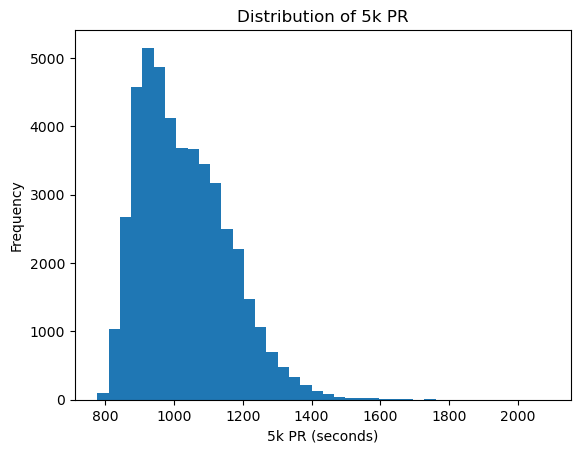

In [ ]:
plt.hist(model_df['5k_pr'], bins=40)
plt.xlabel("5k PR (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of 5k PR")
plt.show()

In [ ]:
model_df.isna().mean().sort_values(ascending=False)

fastest_10000                   0.770723
fastest_10000_days_before_5k    0.760435
fastest_800                     0.573506
fastest_800_days_before_5k      0.568210
avg_5k_before_pr                0.323913
fastest_5k_before_pr            0.323913
fastest_1500                    0.318400
fastest_mile                    0.317011
fastest_1500_days_before_5k     0.313429
fastest_mile_days_before_5k     0.313212
count_5k_before_pr              0.299993
events_30d                      0.015129
events_total                    0.015129
events_365d                     0.015129
events_180d                     0.015129
events_60d                      0.015129
5k_pr                           0.005600
school_state                    0.000347
gender                          0.000087
athlete_id                      0.000000
seniority_days                  0.000000
division                        0.000000
has_800                         0.000000
has_1500                        0.000000
has_mile        

In [ ]:
model_df.corr(numeric_only=True)['5k_pr'].sort_values()


count_5k_before_pr             -0.193779
has_10000                      -0.176955
events_total                   -0.167998
seniority_days                 -0.136036
fastest_800_days_before_5k     -0.122670
fastest_1500_days_before_5k    -0.110322
fastest_mile_days_before_5k    -0.095580
has_1500                       -0.095184
has_mile                       -0.084735
events_365d                    -0.082473
fastest_10000_days_before_5k   -0.077543
events_180d                    -0.025905
events_60d                     -0.011512
events_30d                      0.019617
has_800                         0.032978
improvement                     0.219383
fastest_800                     0.876487
fastest_1500                    0.941127
fastest_mile                    0.942297
fastest_10000                   0.962856
avg_5k_before_pr                0.983092
fastest_5k_before_pr            0.988169
5k_pr                           1.000000
Name: 5k_pr, dtype: float64

In [ ]:
model_df.groupby('gender')['5k_pr'].mean()
#model_df.groupby('school_state')['5k_pr'].mean()


gender
F    1130.682277
M     941.623654
Name: 5k_pr, dtype: float64

In [ ]:
model_df.groupby('division')['5k_pr'].mean()

division
DI       989.038940
DII     1039.454444
DIII    1066.180031
NAIA    1080.305970
Name: 5k_pr, dtype: float64

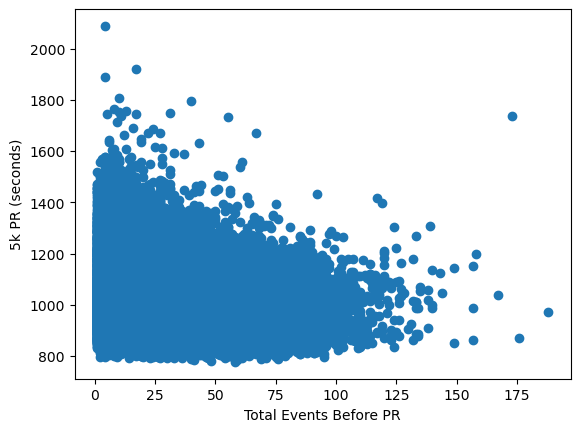

In [ ]:
plt.scatter(model_df['events_total'], model_df['5k_pr'])
plt.xlabel("Total Events Before PR")
plt.ylabel("5k PR (seconds)")
plt.show()


In [ ]:
model_df['improvement'] = model_df['fastest_5k_before_pr'] - model_df['5k_pr']
model_df['improvement'].describe()


count    31148.000000
mean        19.067022
std         19.585194
min          0.000000
25%          6.350000
50%         13.620000
75%         25.040000
max        412.330000
Name: improvement, dtype: float64

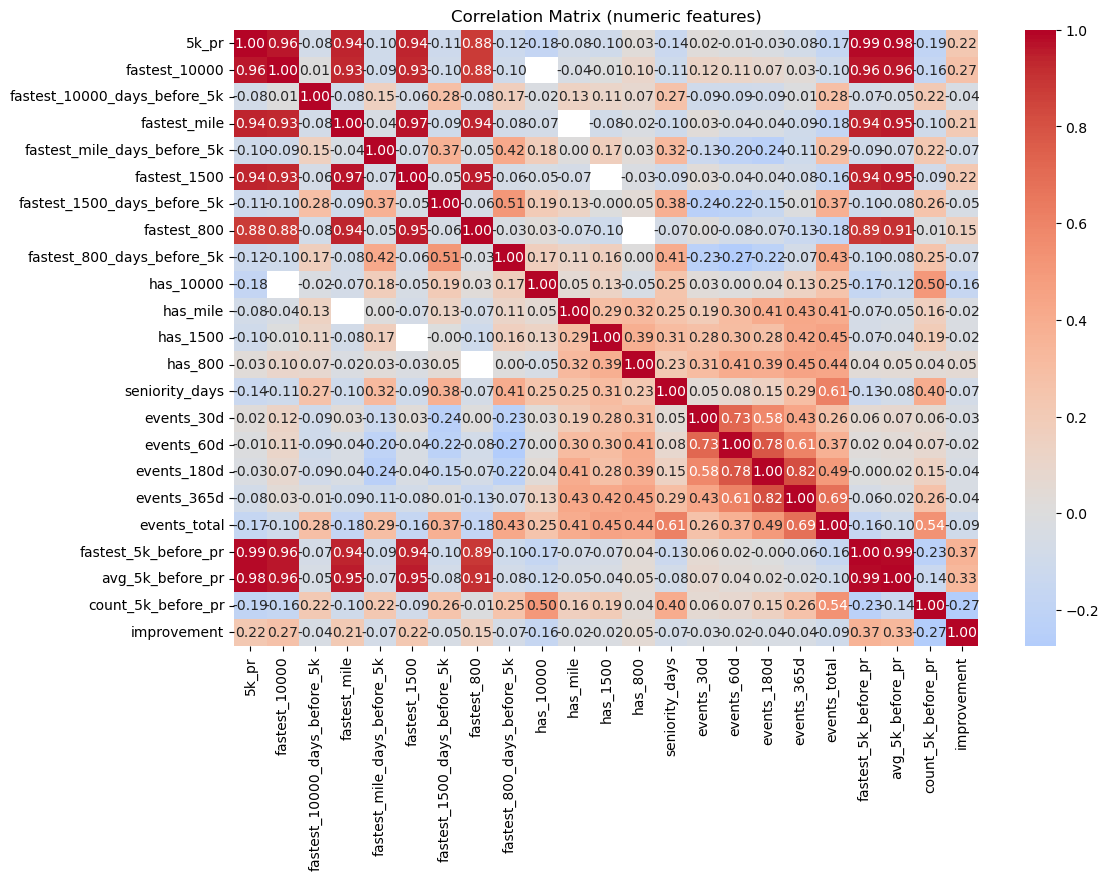

In [ ]:
import seaborn as sns

# Select only numeric columns
numeric_cols = model_df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix (numeric features)")
plt.show()

## build catboost model

In [92]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

In [ ]:


# --------------------------
# 1. Define features & target
# --------------------------
target = '5k_pr'


# drop missing categorical featues
model_df = model_df.dropna(subset=cat_features).reset_index(drop=True)
model_df = model_df.dropna(subset=['5k_pr']).reset_index(drop=True)

# All columns except target and athlete_id
features = model_df.drop(columns=['athlete_id', target]).columns.tolist()

# Identify categorical features
cat_features = ['gender', 'division', 'school_state', 'has_mile', 'has_10000', 'has_10000']  # adjust if needed

# --------------------------
# 2. Train/test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    model_df[features],
    model_df[target],
    test_size=0.2,
    random_state=42
)


In [106]:
# --------------------------
# 3. Create CatBoost Pool objects
# --------------------------
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool  = Pool(data=X_test,  label=y_test,  cat_features=cat_features)


In [107]:
# --------------------------
# 4. Initialize & train CatBoost
# --------------------------
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)

0:	learn: 123.3847687	test: 125.3880154	best: 125.3880154 (0)	total: 156ms	remaining: 2m 35s
100:	learn: 38.7701489	test: 40.6436613	best: 40.6436613 (100)	total: 7.89s	remaining: 1m 10s
200:	learn: 35.1638268	test: 37.4689306	best: 37.4689306 (200)	total: 15s	remaining: 59.7s
300:	learn: 33.2570987	test: 36.1405412	best: 36.1405412 (300)	total: 22s	remaining: 51.2s
400:	learn: 32.1704844	test: 35.5161140	best: 35.5161140 (400)	total: 28.4s	remaining: 42.4s
500:	learn: 31.4276806	test: 35.1440312	best: 35.1440312 (500)	total: 35.4s	remaining: 35.2s
600:	learn: 30.8714577	test: 34.9391999	best: 34.9381787 (597)	total: 42.3s	remaining: 28.1s
700:	learn: 30.3503668	test: 34.7239376	best: 34.7239376 (700)	total: 49.2s	remaining: 21s
800:	learn: 29.8914239	test: 34.5677935	best: 34.5664953 (797)	total: 56.1s	remaining: 13.9s
900:	learn: 29.5123214	test: 34.4637988	best: 34.4603022 (895)	total: 1m 3s	remaining: 6.94s
999:	learn: 29.1434986	test: 34.3533236	best: 34.3529755 (998)	total: 1m 10

RMSE: 34.35
MAE: 16.70
                      Feature Id  Importances
0                         gender    35.562333
1           fastest_5k_before_pr    14.768364
2                   fastest_mile    10.240397
3                   fastest_1500     8.475555
4                       division     8.364039
5               avg_5k_before_pr     8.156056
6                    improvement     3.738194
7             count_5k_before_pr     3.618990
8                   school_state     1.149239
9    fastest_mile_days_before_5k     0.864146
10                   fastest_800     0.802780
11                      has_1500     0.597818
12                  events_total     0.591281
13                seniority_days     0.492371
14                    events_60d     0.474650
15                       pr_date     0.426876
16                   events_180d     0.410939
17   fastest_1500_days_before_5k     0.330443
18                    events_30d     0.315037
19                     has_10000     0.155470
20         

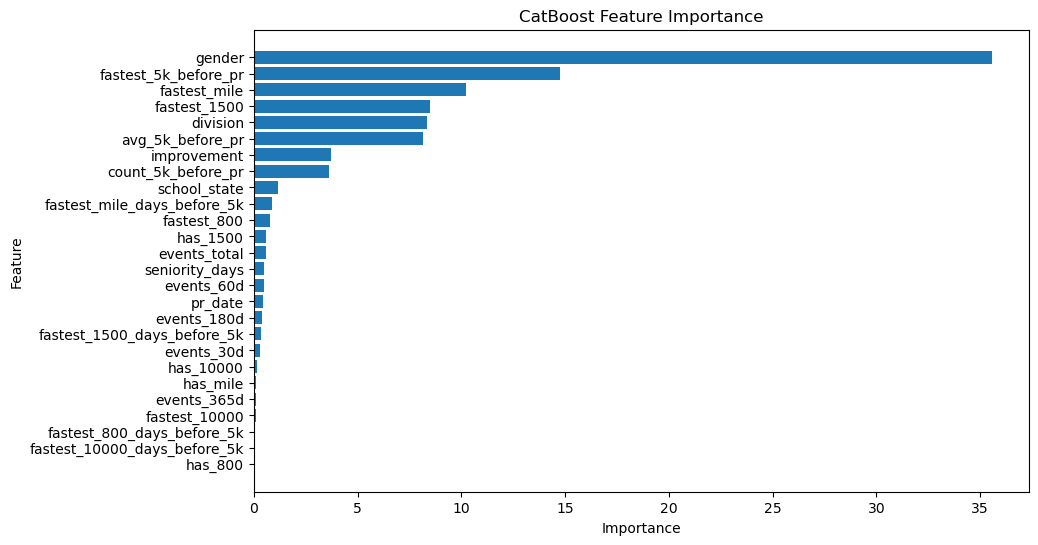

In [108]:
# --------------------------
# 5. Evaluate
# --------------------------
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# --------------------------
# 6. Feature importance
# --------------------------
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

# Optional: plot feature importance
plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## this is not so good. let's try to predict the improvement compared to the previous pr